# Лабораторная работа №4

ФИО:   Людофа Елена Анатольевна

Группа: БИВТ-23-СП-1

Отправлять можно следующими способами:
1. Запушить этот ноутбук в GitHub в репозиторий, где у вас лежат ноутбуки с лабами

Deadlines:
- Занятие №7 в семестре

Что необходимо сделать:  
- Обучить различные модели глубокого обучения на имеющихся данных  

---
## Читайте задание внимательно

Исходные данные:
1. В [табличке](https://docs.google.com/spreadsheets/d/1NOE0D4JQgD6LbvUqWboUI1TFj4P87ugbqUTDquxlGEI/edit?usp=sharing) необходимо узнать название своего датасета
2. Скачать нужны вам данные можно в [Google Drive](https://drive.google.com/drive/folders/1sbsjBsJ_ln0XgXCI9R6s17pvyvApgcwF?usp=sharing)
  
---
Теперь по пунктам, что я от вас жду:  
1. Загрузить необходимые данные к себе и считать (read) их в переменную.
2. Понять, у вас задача классификации (бинарной или многоклассовой) или регрессии.
3. Сделать предобработку данных:  
     1. Разделить выборку на тренировочную (train) и тестовую (test). _Обратите внимание, что обучать скейлеры и определять, какими значениями вы будете заполнять пропуски, вы будете на train выборке, а применять и на train, и на test_.
     2. Проверить пропуски в данных. Если они есть, заполнить одной из стратегий, предложенных в ноутбуке для семинара №3. P.S. Для численных и категориальных переменных будут разные стратегии.
     3. Отнормировать численные переменные (`StandardScaler`, `MinMaxScaler`).
     4. Закодировать категориальные признаки по одной из стратегий.
4. Оформить данные в виде класса `Dataset` из библиотеки `torch` (как мы это делали на семинаре), а затем засунуть в `Dataloader` (тоже делали на семинаре).
5. Обучить на тренировочном множестве:
     1. Очень простую однослойную нейросеть с оптимизатором `SGD` ([link](https://pytorch.org/docs/stable/optim.html)).
     2. Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
     3. Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
6. Посчитайте loss на train и test множествах, в зависимости от эпохи обучения. Провизуализируйте это с помощью библиотеки `matplotlib` (выйдет так называемая **learning curve**, кривая обучения модели).
6. Посчитайте метрики на train и test множествах:
     1. Для задачи классификации -- Accuracy
     2. Для задачи регрессии -- MAE
7. Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:
     1. Какая модель справилась лучше с поставленной задачей?
     2. Имеет ли место переобучение?
     3. Имеет ли место недообучение?
     4. Как можно улучшить метрики моделей?

---
P.S.  
Просьба -- делать каждое задание в отдельных ячейках и с отдельными заголовками (как пункт 1 и 2 в этом ноутбуке) типа  
- Заголовок
- Ячейки с кодом
- Другой заголовок
- Другие ячейки с кодом

P.S.S.  
Если вам повезло с многоклассовой классификацией, у вас не будет проблем, просто нужно будет поставить необходимое количество нейронов на выходе вашей нейросети.

## 1. Пример импорта данных. Грузим данные

In [ ]:
import pandas as pd

data = pd.read_csv("marketing_campaign.csv", sep="\t")

## 2. Понимаем, какая перед нами задача

In [ ]:
"""
Целевая переменная: Response — бинарная (0/1)

Задача бинарной классификации
"""

'\nЦелевая переменная: Response — бинарная (0/1)\n\nЗадача бинарной классификации\n'

## 3. Делаем предобработку данных

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

X = data.drop(columns=['Response'])
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.1,
    random_state=42,
    stratify=y
)

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

num_imputer = SimpleImputer(strategy='median')
X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
X_test[num_cols] = num_imputer.transform(X_test[num_cols])


cat_cols = X_train.select_dtypes(include=['object']).columns

cat_imputer = SimpleImputer(strategy='most_frequent')
X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])
X_test[cat_cols] = cat_imputer.transform(X_test[cat_cols])


ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat = ohe.transform(X_test[cat_cols])

scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num = scaler.transform(X_test[num_cols])

In [ ]:
import numpy as np

X_train_final = np.hstack([X_train_num, X_train_cat])
X_test_final = np.hstack([X_test_num, X_test_cat])

X_train_final.shape, X_test_final.shape

((2016, 697), (224, 697))

## 4. Dataset

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class MarketingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
train_loader = DataLoader(
    MarketingDataset(X_train_final, y_train),
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    MarketingDataset(X_test_final, y_test),
    batch_size=32
)

## 5. Train

In [ ]:
from torch import nn

class SimpleNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.fc(x)


In [ ]:
class MediumNet(nn.Module):
    def __init__(self, input_size, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class DeepNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
def train_model(model, optimizer, epochs=100, name="Model"):
    y_train_all = torch.cat([y for _, y in train_loader])
    pos_weight = torch.tensor([(len(y_train_all) - y_train_all.sum()) / y_train_all.sum()])
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    train_losses = []
    test_losses = []


    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0

        for X_batch, y_batch in train_loader:
            y_batch = y_batch.float().view(-1, 1)

            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        epoch_test_loss = 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                y_batch = y_batch.float().view(-1, 1)
                preds = model(X_batch)
                loss = criterion(preds, y_batch)
                epoch_test_loss += loss.item()

        avg_test_loss = epoch_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        if (epoch+1) % 10 == 0:
            print(f"{name} | Epoch {epoch+1}/{epochs}")
            print(f"  Train Loss: {avg_train_loss:.4f}")
            print(f"  Test Loss:  {avg_test_loss:.4f}")
            print("-" * 50)

    return train_losses, test_losses

In [ ]:
import torch.optim as optim
input_size = X_train_final.shape[1]

model1 = SimpleNet(input_size)
opt1 = optim.SGD(model1.parameters(), lr=0.01)
print("Обучаем SimpleNet (SGD)...")
train1, test1 = train_model(model1, opt1, epochs=100, name="SimpleNet (SGD)")

model2 = MediumNet(input_size)
opt2 = optim.Adam(model2.parameters(), lr=0.001)
print("\nОбучаем MediumNet (Adam)...")
train2, test2 = train_model(model2, opt2, epochs=100, name="MediumNet (Adam)")

model3 = DeepNet(input_size)
opt3 = optim.Adam(model3.parameters(), lr=0.0001)
print("\nОбучаем DeepNet (Adam)...")
train3, test3 = train_model(model3, opt3, epochs=100, name="DeepNet (Adam)")

Обучаем SimpleNet (SGD)...
SimpleNet (SGD) | Epoch 10/100
  Train Loss: 0.7694
  Test Loss:  0.7556
--------------------------------------------------
SimpleNet (SGD) | Epoch 20/100
  Train Loss: 0.7358
  Test Loss:  0.7208
--------------------------------------------------
SimpleNet (SGD) | Epoch 30/100
  Train Loss: 0.7224
  Test Loss:  0.7043
--------------------------------------------------
SimpleNet (SGD) | Epoch 40/100
  Train Loss: 0.7150
  Test Loss:  0.6972
--------------------------------------------------
SimpleNet (SGD) | Epoch 50/100
  Train Loss: 0.7094
  Test Loss:  0.6930
--------------------------------------------------
SimpleNet (SGD) | Epoch 60/100
  Train Loss: 0.7050
  Test Loss:  0.6871
--------------------------------------------------
SimpleNet (SGD) | Epoch 70/100
  Train Loss: 0.7014
  Test Loss:  0.6839
--------------------------------------------------
SimpleNet (SGD) | Epoch 80/100
  Train Loss: 0.6978
  Test Loss:  0.6815
--------------------------------

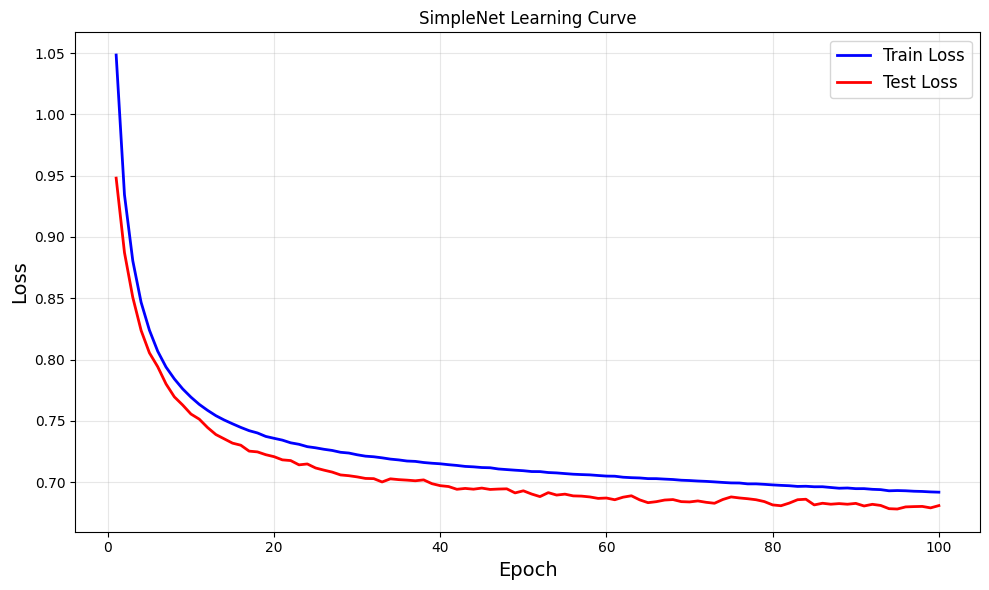

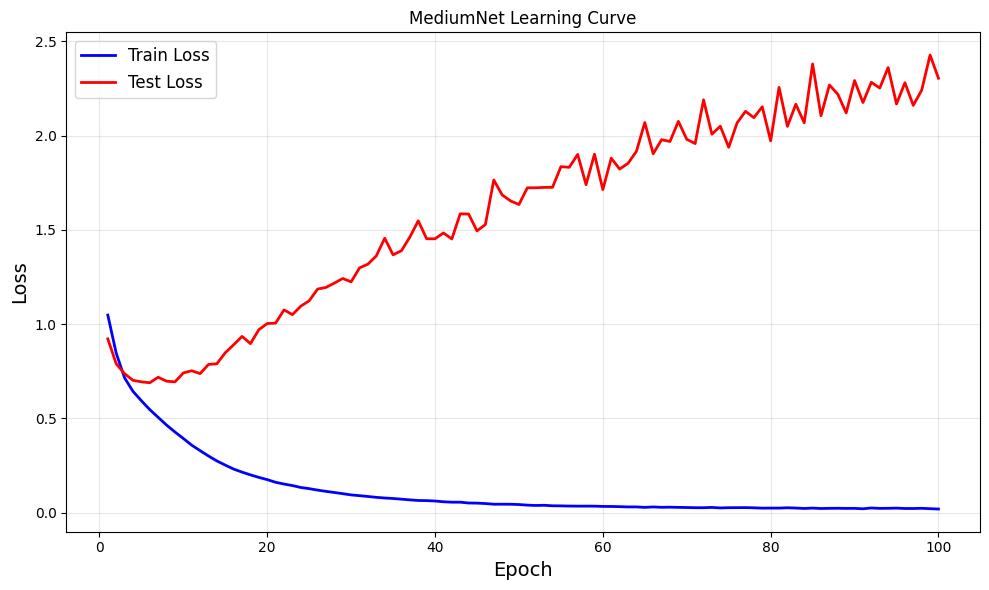

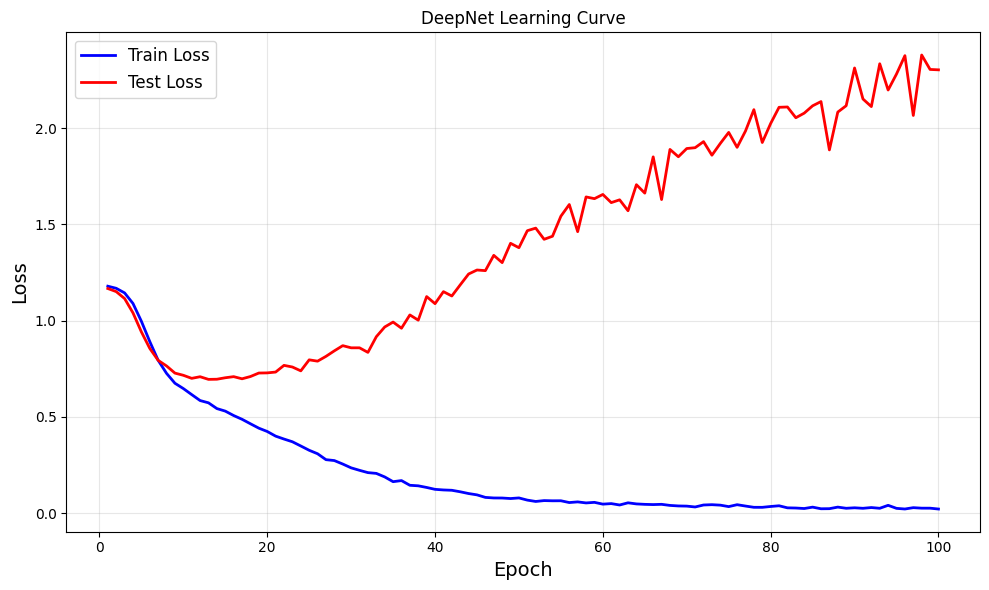

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
epochs = range(1, len(train1) + 1)
plt.plot(epochs, train1, label='Train Loss', linewidth=2, color='blue')
plt.plot(epochs, test1,  label='Test Loss',  linewidth=2, color='red')
plt.title("SimpleNet Learning Curve")
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

print('\n\n')

plt.figure(figsize=(10,6))
epochs = range(1, len(train2) + 1)
plt.plot(epochs, train2, label='Train Loss', linewidth=2, color='blue')
plt.plot(epochs, test2,  label='Test Loss',  linewidth=2, color='red')
plt.title("MediumNet Learning Curve")
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

print('\n\n')

plt.figure(figsize=(10,6))
epochs = range(1, len(train3) + 1)
plt.plot(epochs, train3, label='Train Loss', linewidth=2, color='blue')
plt.plot(epochs, test3,  label='Test Loss',  linewidth=2, color='red')
plt.title("DeepNet Learning Curve")
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

def evaluate(model):
    model.eval()
    preds, true = [], []

    with torch.no_grad():
        for Xb, yb in test_loader:
            logits = model(Xb)
            preds.extend((torch.sigmoid(logits) > 0.5).int().numpy())
            true.extend(yb.numpy())

    return accuracy_score(true, preds)

from sklearn.metrics import accuracy_score

print("SimpleNet:", evaluate(model1))
print("MediumNet:", evaluate(model2))
print("DeepNet:", evaluate(model3))



SimpleNet: 0.8392857142857143
MediumNet: 0.8526785714285714
DeepNet: 0.8705357142857143
